In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [15]:
filename = "../data/hdfc_usable.csv"
df = pd.read_csv(filename)
df.head()

,Symbol,Open Price,High,Low,Close Price,Total Traded Quantity,Total Traded Value,Date,Average Trading Price
0,HDFC,2418.00,2438.50,2409.0,2433.95,945874,2.294534e+09,01-Jan-20,2425.834653
1,HDFC,2430.00,2472.75,2422.0,2466.40,1701396,4.169605e+09,02-Jan-20,2450.696553
2,HDFC,2455.00,2466.40,2441.8,2454.45,1963923,4.815298e+09,03-Jan-20,2451.877371
3,HDFC,2428.00,2445.00,2371.4,2384.10,2656731,6.365761e+09,06-Jan-20,2396.087914
4,HDFC,2401.25,2428.80,2380.2,2415.05,3771992,9.078865e+09,07-Jan-20,2406.915132


### Define all the technical Indicators here if not using built in function 

In [16]:
def simple_moving_average(data:pd.DataFrame, ndays:int): 
    """
    Function to find the Simple Moving Average. Since this data is weekly, this variable can be updated on a weekly basis, i.e. 
    the data of each week is used to compute the average
    """
    SMA = pd.Series(data['Close Price'].rolling(ndays).mean(), name = 'SMA') 
    data = data.join(SMA) 
    return data

def expo_weighted_moving_average(data, ndays): 
    """
    Function to find the Simple Moving Average. Since this data is weekly, this variable can be updated on a weekly basis, i.e. 
    the data of each week is used to compute the average
    """
    EMA = pd.Series(data['Close Price'].ewm(span = ndays, min_periods = ndays - 1).mean(), 
                 name = 'EWMA' + str(ndays)) 
    data = data.join(EMA) 
    return data

def bollinger_bands(data, window):
    """
    Function to create bollinger bands, the gap between these bands determines the volatility of that stock  
    """
    MA = data['Close Price'].rolling(window).mean()
    SD = data['Close Price'].rolling(window).std()
    data['MiddleBand'] = MA
    data['UpperBand'] = MA + (2 * SD) 
    data['LowerBand'] = MA - (2 * SD)
    return data

def relative_strength_index(close, periods = 2):
    """
    Function to create the Relative Strength Index
    """
        
    close_delta = close.diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()

    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi


def gain(x):
    return ((x > 0) * x).sum()


def loss(x):
    return ((x < 0) * x).sum()


def mfi(high, low, close, volume, n=2):
    typical_price = (high + low + close)/3
    money_flow = typical_price * volume
    mf_sign = np.where(typical_price > typical_price.shift(1), 1, -1)
    signed_mf = money_flow * mf_sign
    mf_avg_gain = signed_mf.rolling(n).apply(gain, raw=True)
    mf_avg_loss = signed_mf.rolling(n).apply(loss, raw=True)
    return (100 - (100 / (1 + (mf_avg_gain / abs(mf_avg_loss))))).to_numpy()

def force_index(df, ndays): 
    FI = pd.Series(df['Close Price'].diff(ndays) * df['Total Traded Quantity'], name = 'ForceIndex') 
    df = df.join(FI) 
    return df

def average_true_range(high, low, close, n=14):
    tr = np.amax(np.vstack(((high - low).to_numpy(), (abs(high - close)).to_numpy(), (abs(low - close)).to_numpy())).T, axis=1)
    return pd.Series(tr).rolling(n).mean().to_numpy()

def ease_of_movement(data, ndays): 
    dm = ((data['High'] + data['Low'])/2) - ((data['High'].shift(1) + data['Low'].shift(1))/2)
    br = (data['Total Traded Quantity'] / 100000000) / ((data['High'] - data['Low']))
    EMV = dm / br 
    EMV_MA = pd.Series(EMV.rolling(ndays).mean(), name = 'EMV') 
    data = data.join(EMV_MA) 
    return data 



In [17]:
n = 5
sma = simple_moving_average(df,n)
df = sma

n = 5
ewma = expo_weighted_moving_average(df,n)
df = ewma

n = 5
bb = bollinger_bands(df,n)
df = bb

df['RSI'] = relative_strength_index(df['Close Price'])

df['MFI'] = mfi(df['High'], df['Low'], df['Close Price'], df['Total Traded Quantity'], 14)
df = force_index(df,1)
df['ATR'] = average_true_range(df['High'], df['Low'], df['Close Price'], 2)

df = ease_of_movement(df,2)

df.head() 

,Symbol,Open Price,High,Low,Close Price,Total Traded Quantity,Total Traded Value,Date,Average Trading Price,SMA,EWMA5,MiddleBand,UpperBand,LowerBand,RSI,MFI,ForceIndex,ATR,EMV
0,HDFC,2418.00,2438.50,2409.0,2433.95,945874,2.294534e+09,01-Jan-20,2425.834653,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HDFC,2430.00,2472.75,2422.0,2466.40,1701396,4.169605e+09,02-Jan-20,2450.696553,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.521030e+07,40.125,NaN
2,HDFC,2455.00,2466.40,2441.8,2454.45,1963923,4.815298e+09,03-Jan-20,2451.877371,NaN,NaN,NaN,NaN,NaN,57.586513,NaN,-2.346888e+07,37.675,39446.703197
3,HDFC,2428.00,2445.00,2371.4,2384.10,2656731,6.365761e+09,06-Jan-20,2396.087914,NaN,2424.910769,NaN,NaN,NaN,9.607698,NaN,-1.869010e+08,49.100,-59367.036521
4,HDFC,2401.25,2428.80,2380.2,2415.05,3771992,9.078865e+09,07-Jan-20,2406.915132,2430.79,2421.125355,2430.79,2496.101232,2365.478768,47.843171,NaN,1.167432e+08,61.100,-65962.508160


### Visualising these technical Indicators

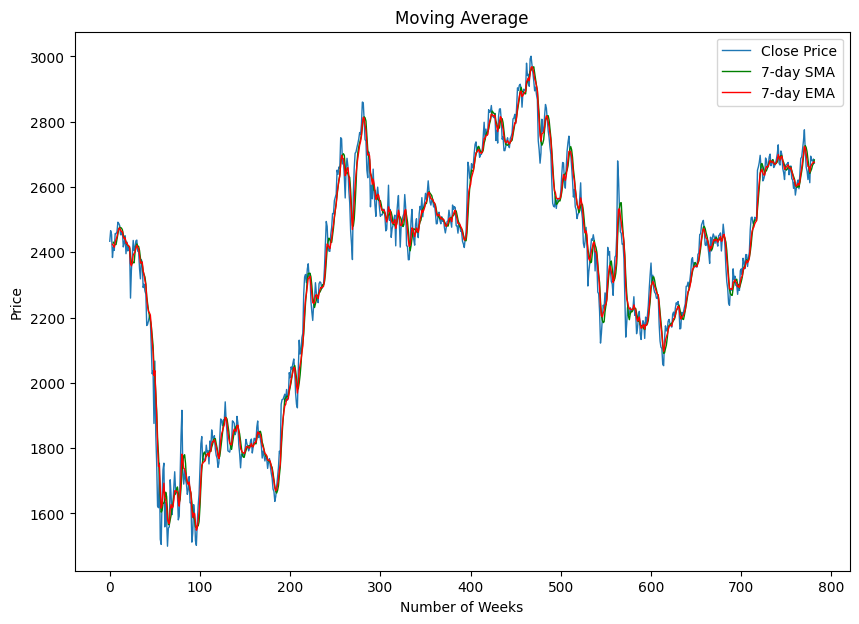

In [18]:
plt.figure(figsize=(10,7))

# Set the title and axis labels
plt.title('Moving Average')
plt.xlabel('Number of Weeks')
plt.ylabel('Price')

# Plot close price and moving averages
plt.plot(df['Close Price'],lw=1, label='Close Price')
plt.plot(df['SMA'],'g',lw=1, label='7-day SMA')
plt.plot(df['EWMA5'],'r', lw=1, label='7-day EMA')

# Add a legend to the axis
plt.legend()

plt.show()

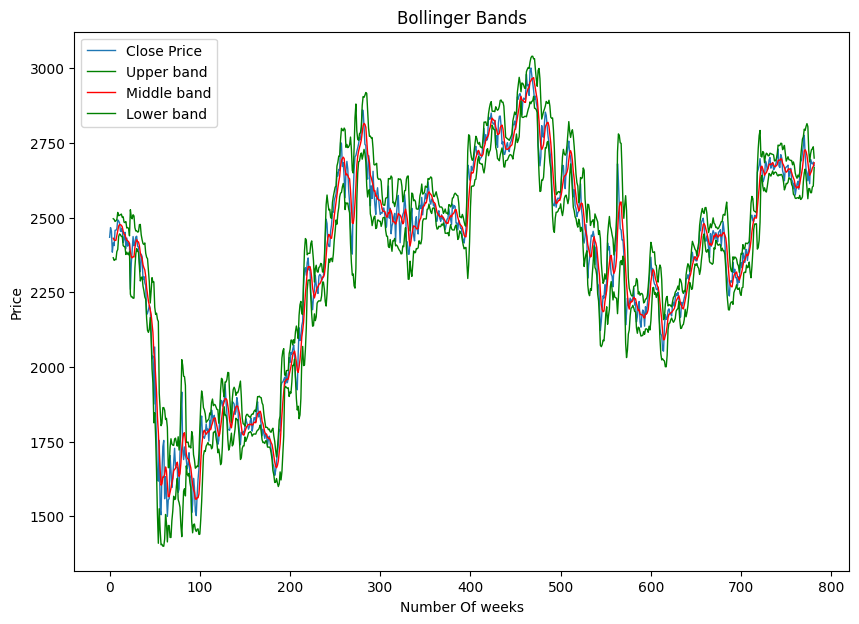

In [19]:
plt.figure(figsize=(10,7))

# Set the title and axis labels
plt.title('Bollinger Bands')
plt.xlabel('Number Of weeks')
plt.ylabel('Price')

plt.plot(df['Close Price'],lw=1, label='Close Price')
plt.plot(df['UpperBand'],'g',lw=1, label='Upper band')
plt.plot(df['MiddleBand'],'r',lw=1, label='Middle band')
plt.plot(df['LowerBand'],'g', lw=1, label='Lower band')

# Add a legend to the axis
plt.legend()

plt.show()

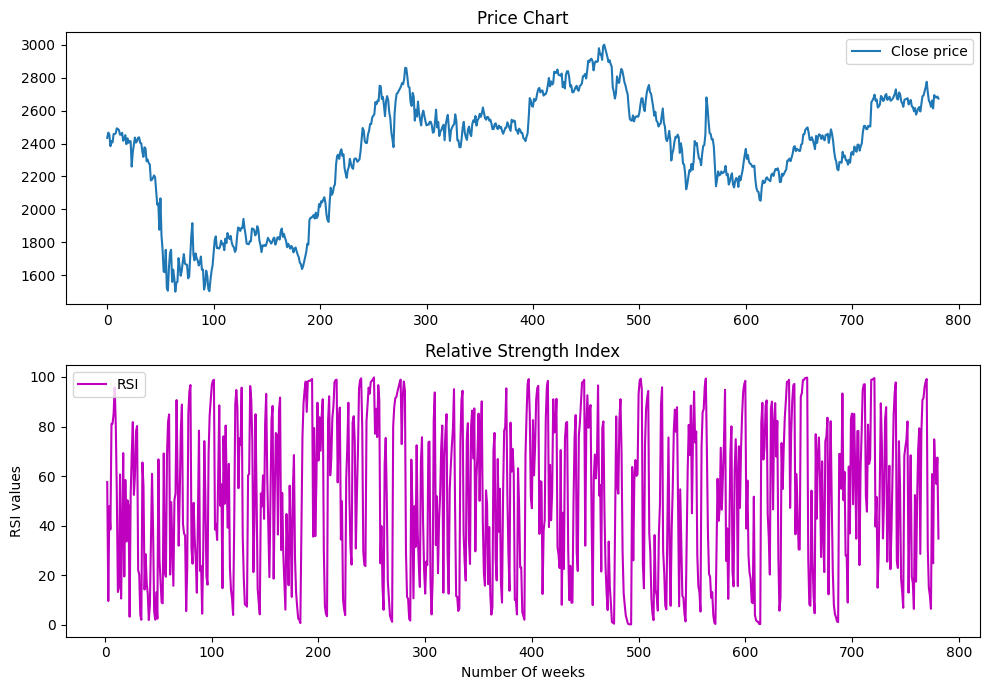

In [20]:
fig = plt.figure(figsize=(10, 7))

# Define position of 1st subplot
ax = fig.add_subplot(2, 1, 1)

# Set the title and axis labels
plt.title('Price Chart')
plt.plot(df['Close Price'], label='Close price')

# Add a legend to the axis
plt.legend()
# Define position of 2nd subplot
bx = fig.add_subplot(2, 1, 2)

# Set the title and axis labels
plt.title('Relative Strength Index')
plt.xlabel('Number Of weeks')
plt.ylabel('RSI values')

plt.plot(df['RSI'], 'm', label='RSI')

# Add a legend to the axis
plt.legend()

plt.tight_layout()
plt.show()

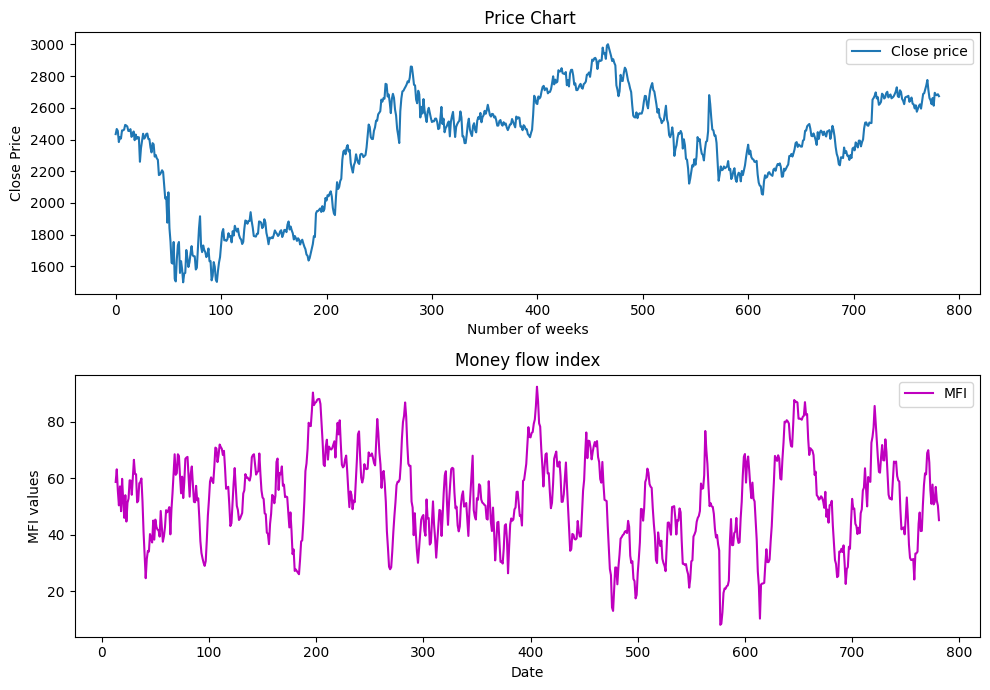

In [21]:
fig = plt.figure(figsize=(10, 7))

# Define position of 1st subplot
ax = fig.add_subplot(2, 1, 1)
# Set the title and axis labels
plt.title(' Price Chart')
plt.xlabel('Number of weeks')
plt.ylabel('Close Price')

plt.plot(df['Close Price'], label='Close price')

# Add a legend to the axis
plt.legend()

# Define position of 2nd subplot
bx = fig.add_subplot(2, 1, 2)

# Set the title and axis labels
plt.title('Money flow index')
plt.xlabel('Date')
plt.ylabel('MFI values')

plt.plot(df['MFI'], 'm', label='MFI')

# Add a legend to the axis
plt.legend()

plt.tight_layout()
plt.show()

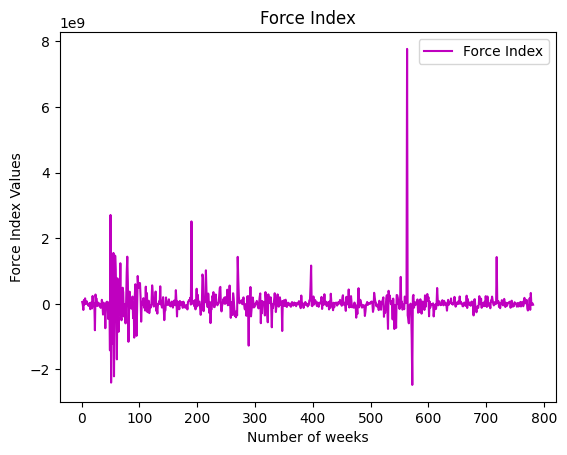

In [22]:
plt.title('Force Index')
plt.xlabel('Number of weeks')
plt.ylabel('Force Index Values')

plt.plot(df['ForceIndex'], 'm', label='Force Index')

# Add a legend to the axis
plt.legend()

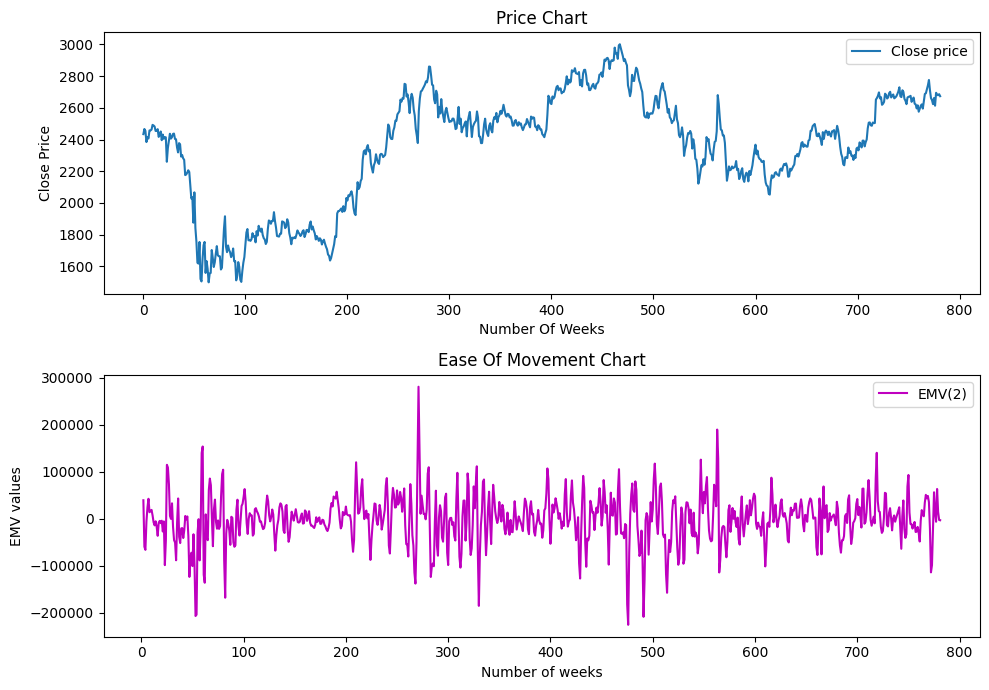

In [23]:
fig = plt.figure(figsize=(10, 7))

# Define position of 1st subplot
ax = fig.add_subplot(2, 1, 1)

# Set the title and axis labels
plt.title('Price Chart')
plt.xlabel('Number Of Weeks')
plt.ylabel('Close Price')

# Plot the close price of the Apple
plt.plot(df['Close Price'], label='Close price')

# Add a legend to the axis
plt.legend()

# Define position of 2nd subplot
bx = fig.add_subplot(2, 1, 2)

# Set the title and axis labels
plt.title('Ease Of Movement Chart')
plt.xlabel('Number of weeks')
plt.ylabel('EMV values')

# Plot the ease of movement
plt.plot(df['EMV'], 'm', label='EMV(2)')

# Add a legend to the axis
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
df.to_csv("../data/hdfc_data_indicators.csv", index=False)